## Ghost Writer Training Test

In [246]:
import pandas as pd
import numpy as np
import ast
import re
import unicodedata

In [472]:
hip = pd.read_csv('hiphop_corpus_with_lyrics.csv')

## Data PreProcessing

Since writers is currently stored as a string gonna convert to list

In [473]:
hip['writers'] = hip['writers'].apply(ast.literal_eval)

Break up lyrics by Verse

Will make sense later, but this song Drake doesn't speak once and is fully Kendrick speaking. Makes for sense for it to be added to Kendricks training data instead 

In [474]:
hip.loc[316,'artist'] = 'Kendrick Lamar'

Cleaning up data as these songs were pulled under another but really it was released by antoher

In [475]:
hip.loc[1227:1233,'artist'] = "Kanye West"
hip.loc[1235,'artist'] = "Kanye West"
hip.loc[1242:1249,'artist'] = "Drake"
hip.loc[1480,'artist'] = "Drake"
hip.loc[1574,'artist'] = "Drake"
hip.loc[1675,'artist'] = "Kendrick Lamar"
hip.loc[1710,'artist'] = "Jay-Z"

Getting lyrics that was written by the artist. First will get who sang the verse and will then keep only the verses they were a part of

In [273]:
# Fixed version with hyphen normalization
def normalize_artist_name(name):
    if not name:
        return ""

    # 1. unicode normalize (NFKD) -> removes accents/diacritics
    name = unicodedata.normalize("NFKD", name)

    # 2. lowercase and trim
    name = name.lower().strip()

    # 3. turn one-or-more dollar signs into a single 's'
    name = re.sub(r'\$+', 's', name)

    # 4. unify common separators to spaces (hyphens/underscores/ampersand/at/slash)
    name = re.sub(r'[-_&@/]+', ' ', name)

    # 5. remove any remaining punctuation (keep letters, numbers, spaces)
    #    note: \w includes underscore; we've already removed underscores above
    name = re.sub(r'[^a-z0-9\s]', '', name)

    # 6. collapse whitespace and strip
    name = re.sub(r'\s+', ' ', name).strip()
    
    if name in ['tyler','the creator']:
        return 'tyler the creator'
    
    return name

In [164]:
def extract_artists(section):
    """
    Extracts artists from a bracketed song section like:
    [Intro: Bēkon & Kid Capri]
    
    Returns:
        list of artist names OR None if no artists exist.
    """
    if section is None:
        return None

    # Step 1: detect pattern like: [Intro: artist(s)]
    match = re.match(r"\[(?:[^\]:]+)(?::\s*(.*?))?\]$", section.strip())
    if not match:
        return None

    artists_str = match.group(1)  # captures everything after the colon
    
    # Step 2: return None if no artist portion exists
    if not artists_str or artists_str.strip() == "":
        return None

    # Step 3: split artists by “&” or “,” and clean
    artists = re.split(r"&|,|\band\b", artists_str)
    artists = [a.strip() for a in artists if a.strip() != ""]

    return artists if artists else None


Creating a row to get lyrics for artist if they are featured on a song but not currently added to songs in their discography in my dataset

In [287]:
def get_featured_artist(row):
    blocks = re.split(r'(\[[^\]]+\])', row['lyrics'])
    prim_art = normalize_artist_name(row['artist'])
    
    featured_art = []
    seen = set()
    
    for i in range(len(blocks)):
        artist = extract_artists(blocks[i])
        if artist is not None:
            for a in artist:
                art = normalize_artist_name(a)
                
                if art in ["q tip", "phife dawg", "ali shaheed muhammad"]:
                    art = "A Tribe Called Quest"
                if art not in seen and art != prim_art:
                    seen.add(art)
                    featured_art.append(a)
    
    if len(featured_art)==0:
        return None
    
    return featured_art

In [476]:
hip['featured_artist'] = hip.apply(
    lambda row: get_featured_artist(row),
    axis=1
)
hip

,artist,album,song_title,date,writers,lyrics,title_clean,featured_artist
0,Mac Miller,Circles,Circles,"January 17, 2020",[Mac Miller],"[Verse 1]\nWell, this is what it look like rig...",circles,None
1,Mac Miller,Circles,Complicated,"January 17, 2020","[Mac Miller, Jon Brion]","[Verse 1]\nOutside is cloudy, but I like that ...",complicated,None
2,Mac Miller,Circles,Blue World,"January 17, 2020","[Mac Miller, Guy Lawrence, Robert Craig Wright...",[Intro: The Four Freshman]\nIt's a blue world ...,blue world,[The Four Freshman]
3,Mac Miller,Circles,Good News,"January 9, 2020","[Mac Miller, Jon Brion]",[Verse 1]\nI spent the whole day in my head\nD...,good news,None
4,Mac Miller,Circles,I Can See,"January 17, 2020","[Mac Miller, Shea Taylor]","[Verse 1]\nI'm so close, I can taste it\nThe m...",i can see,None
...,...,...,...,...,...,...,...,...
1787,Joey Bada$$,AmeriKKKan Korruption: Reloaded,Dead Prez,"April 7, 2012",[Capital STEEZ],"[Verse 1]\nI'm green and inexperienced, dreami...",dead prez,None
1788,Joey Bada$$,Summer Knights,Right on Time,"July 1, 2013",[Joey Bada$$],[Refrain: Tweet]\nMy eyes have never seen some...,right on time,[Tweet]
1789,Joey Bada$$,These Days…,Tree of Life,"April 18, 2014","[Curtiss King, Dahi, Joey Bada$$, Ab-Soul]",[Part I: Produced by Curtiss King]\n\n[Intro: ...,tree of life,"[Produced by Curtiss King, Audra the Rapper + ..."
1790,Joey Bada$$,PEEP: The aPROcalypse,School High,"December 21, 2012","[brandUn DeShay, Joey Bada$$, Kirk Knight, Nyc...",[Produced by brandUn DeShay]\n\n[Intro: Joey B...,school high,"[Dyemond Lewis, Kirk Knight, Nyck Caution]"


In [477]:
all_artists = hip['artist'].unique().tolist()

featured = hip['featured_artist']

need_row = []
new_rows = []

for row in hip.itertuples(index=True):
    idx = row.Index
    feat_list = row.featured_artist
    
    if feat_list is None:
        continue
    for f in feat_list:
        if f in all_artists:
            song_feat_in = row.title_clean
            art_discogrophy = hip[hip['artist']==f]['title_clean']
            
            if song_feat_in not in art_discogrophy:
                need_row.append(idx)
                
                #swapping featured list to be correct
                new_feat = []
                for cur_f in row.featured_artist:
                    if cur_f == f:
                        new_feat.append(row.artist)
                    else:
                        new_feat.append(cur_f)
                        
                new_rows.append({'artist': f, 
                               'album': row.album,
                               'song_title': row.song_title,
                               'date': row.date,
                               'writers': row.writers,
                               'lyrics': row.lyrics,
                               'title_clean': row.title_clean,
                               'featured_artist': new_feat})
                
hip = pd.concat([hip, pd.DataFrame(new_rows)], ignore_index=True)
hip

,artist,album,song_title,date,writers,lyrics,title_clean,featured_artist
0,Mac Miller,Circles,Circles,"January 17, 2020",[Mac Miller],"[Verse 1]\nWell, this is what it look like rig...",circles,None
1,Mac Miller,Circles,Complicated,"January 17, 2020","[Mac Miller, Jon Brion]","[Verse 1]\nOutside is cloudy, but I like that ...",complicated,None
2,Mac Miller,Circles,Blue World,"January 17, 2020","[Mac Miller, Guy Lawrence, Robert Craig Wright...",[Intro: The Four Freshman]\nIt's a blue world ...,blue world,[The Four Freshman]
3,Mac Miller,Circles,Good News,"January 9, 2020","[Mac Miller, Jon Brion]",[Verse 1]\nI spent the whole day in my head\nD...,good news,None
4,Mac Miller,Circles,I Can See,"January 17, 2020","[Mac Miller, Shea Taylor]","[Verse 1]\nI'm so close, I can taste it\nThe m...",i can see,None
...,...,...,...,...,...,...,...,...
1842,2Pac,Unsolved Mysteries: Mystery Two Harlem’s Fines...,Deadly Combination (Remix),"June 28, 2006","[The Notorious B.I.G., Big L]","[Intro: Ron G & 2Pac]\nYes, indeed\nIt's the m...",deadly combination,"[Ron G, Big L, The Notorious B.I.G.]"
1843,2Pac,NaN,Juice (DJ Cinema remix),"January 1, 1991","[Big Pun, Big L, 2Pac]","[Verse One: 2Pac]\nTell me, how many real moth...",juice,"[Big L, Big Pun]"
1844,Kanye West,Cherry Bomb + Instrumentals,SMUCKERS,"April 13, 2015","[Gabriele Ducros, Lil Wayne, Kanye West, Tyler...","[Part I]\n\n[Chorus: Tyler, The Creator]\nFor ...",smuckers,"[Tyler, The Creator]"
1845,Kendrick Lamar,Super Bowl Halftime Shows,Super Bowl LVI Halftime Show,"February 13, 2022","[Dr. Dre, Snoop Dogg, Mel-Man, David Axelrod, ...","Setlist""The Next Episode"" (Dr. Dre and Snoop D...",super bowl lvi halftime show,"[Snoop Dogg, Roger Troutman, ""m.A.A.d City"" — ..."


In [165]:
def get_main_artist_verses(lyrics, main_artist, corpus_artists):
    
    # Normalize everything to lowercase
    main_artist = normalize_artist_name(main_artist)
    corpus_artists = [normalize_artist_name(c) for c in corpus_artists]

    # Split lyrics into [Header][Text]
    blocks = re.split(r'(\[[^\]]+\])', lyrics)
    verses = []

    for i in range(len(blocks)):
        header = blocks[i]

        # Only process bracketed headers
        if not re.match(r"\[.*?\]", header):
            continue

        text = blocks[i+1] if i + 1 < len(blocks) else ""

        # CASE 1 — No colon → no artist info → keep automatically
        if ":" not in header:
            cleaned = re.sub(r"\(.*?\)", "", text, flags=re.DOTALL)
            verses.append(cleaned.strip())
            continue

        # CASE 2 — Colon exists → try to extract artists
        artists = extract_artists(header)

        # If colon exists but extract_artists returns None → fallback to keep
        if artists is None:
            cleaned = re.sub(r"\(.*?\)", "", text, flags=re.DOTALL)
            verses.append(cleaned.strip())
            continue

        # Normalize
        artists = [normalize_artist_name(a) for a in artists]

        # If artist not listed → skip
        if main_artist not in artists:
            continue

        # Now artist is in (e.g., [Verse: Kendrick Lamar])
        art_index = artists.index(main_artist)

        if art_index == 0:
            # main voice generally in first index → remove adlibs
            cleaned = re.sub(r"\(.*?\)", "", text, flags=re.DOTALL)
            verses.append(cleaned.strip())
        else:
            # after is generally set as background artist → grab only the parentheses lines
            adlibs = re.findall(r"\((.*?)\)", text, flags=re.DOTALL)
            verses.extend([a.strip() for a in adlibs])


    return verses

In [478]:
hip['main_artist_lyrics'] = hip.apply(
    lambda row: get_main_artist_verses(row['lyrics'], row['artist'], all_artists),
    axis=1
)

# Join the verses back into a single string per song
hip['main_artist_lyrics_joined'] = hip['main_artist_lyrics'].apply(lambda x: "\n".join(x))

#cleaning by removing \n
hip['main_artist_lyrics_joined'] = hip['main_artist_lyrics_joined'].str.replace('\n', ' ')
hip.head()

,artist,album,song_title,date,writers,lyrics,title_clean,featured_artist,main_artist_lyrics,main_artist_lyrics_joined
0,Mac Miller,Circles,Circles,"January 17, 2020",[Mac Miller],"[Verse 1]\nWell, this is what it look like rig...",circles,None,"[Well, this is what it look like right before ...","Well, this is what it look like right before y..."
1,Mac Miller,Circles,Complicated,"January 17, 2020","[Mac Miller, Jon Brion]","[Verse 1]\nOutside is cloudy, but I like that ...",complicated,None,"[Outside is cloudy, but I like that better \nB...","Outside is cloudy, but I like that better Beh..."
2,Mac Miller,Circles,Blue World,"January 17, 2020","[Mac Miller, Guy Lawrence, Robert Craig Wright...",[Intro: The Four Freshman]\nIt's a blue world ...,blue world,[The Four Freshman],"[Yeah, well, this a mad world, it made me craz...","Yeah, well, this a mad world, it made me crazy..."
3,Mac Miller,Circles,Good News,"January 9, 2020","[Mac Miller, Jon Brion]",[Verse 1]\nI spent the whole day in my head\nD...,good news,None,[I spent the whole day in my head\nDo a little...,I spent the whole day in my head Do a little s...
4,Mac Miller,Circles,I Can See,"January 17, 2020","[Mac Miller, Shea Taylor]","[Verse 1]\nI'm so close, I can taste it\nThe m...",i can see,None,"[I'm so close, I can taste it\nThe man on the ...","I'm so close, I can taste it The man on the mo..."


In [167]:
group_members = {
    "A Tribe Called Quest": ["Q-Tip", "Phife Dawg", "Ali Shaheed Muhammad"]
}

def flag_missing_header_artists(lyrics, main_artist, writers, corpus_artists, group_members=None):
    """
    Returns 1 if the lyric header does NOT include the main artist,
    and also does NOT include any other contributing artists from our corpus.
    """
    # Determine allowed names for the main artist
    allowed_artists = group_members.get(main_artist, [main_artist]) if group_members else [main_artist]
    allowed_artists = [a.lower() for a in allowed_artists]
    
    # Get all lyric headers in the song
    headers = re.findall(r'\[(?:[^\]:]*?:\s*)([^\]]+)\]', lyrics)
    
    # Split header artists by & / and, flatten all headers
    header_artists = []
    for h in headers:
        header_artists.extend([a.strip().lower() for a in re.split(r'\s*(?:&|and)\s*', h)])
    
    # Check if main artist is in any header
    main_in_header = any(a in allowed_artists for a in header_artists)
    
    # Get all other contributing artists from writers who are in our corpus
    other_contributors = [w for w in writers if w in corpus_artists and w != main_artist]
    
    # Check if any of these contributors appear in the headers
    contributor_in_header = any(a in other_contributors for a in header_artists)
    
    # Flag = 1 if main artist not in header and none of the other contributors are in header
    if not main_in_header and not contributor_in_header and len(other_contributors) > 0:
        return 1, other_contributors
    return 0, None


In [479]:
hip[['pot_ghost', 'pot_ghost_name']] = hip.apply(
    lambda row: pd.Series(flag_missing_header_artists(
        row['lyrics'],
        row['artist'],
        row['writers'],
        all_artists,
        group_members
    )),
    axis=1
)
hip.head()

,artist,album,song_title,date,writers,lyrics,title_clean,featured_artist,main_artist_lyrics,main_artist_lyrics_joined,pot_ghost,pot_ghost_name
0,Mac Miller,Circles,Circles,"January 17, 2020",[Mac Miller],"[Verse 1]\nWell, this is what it look like rig...",circles,None,"[Well, this is what it look like right before ...","Well, this is what it look like right before y...",0.0,NaN
1,Mac Miller,Circles,Complicated,"January 17, 2020","[Mac Miller, Jon Brion]","[Verse 1]\nOutside is cloudy, but I like that ...",complicated,None,"[Outside is cloudy, but I like that better \nB...","Outside is cloudy, but I like that better Beh...",0.0,NaN
2,Mac Miller,Circles,Blue World,"January 17, 2020","[Mac Miller, Guy Lawrence, Robert Craig Wright...",[Intro: The Four Freshman]\nIt's a blue world ...,blue world,[The Four Freshman],"[Yeah, well, this a mad world, it made me craz...","Yeah, well, this a mad world, it made me crazy...",0.0,NaN
3,Mac Miller,Circles,Good News,"January 9, 2020","[Mac Miller, Jon Brion]",[Verse 1]\nI spent the whole day in my head\nD...,good news,None,[I spent the whole day in my head\nDo a little...,I spent the whole day in my head Do a little s...,0.0,NaN
4,Mac Miller,Circles,I Can See,"January 17, 2020","[Mac Miller, Shea Taylor]","[Verse 1]\nI'm so close, I can taste it\nThe m...",i can see,None,"[I'm so close, I can taste it\nThe man on the ...","I'm so close, I can taste it The man on the mo...",0.0,NaN


Getting rid of rows where the main artist doesn't have any lyrics in the song

In [480]:
hip = hip[hip['main_artist_lyrics_joined'].fillna('').str.strip() != '']
hip = hip.reset_index(drop=True)

In [424]:
artists = ["Mac Miller", "Kendrick Lamar", "Quentin Miller", "Drake", "J. Cole", "A Tribe Called Quest", "Kanye West", "Soulja Boy","Jay-Z", "Big L", "Children of the Corn","Tyler, The Creator", "2Pac", "Joey Bada$$"]

target_albums = {
    "Mac Miller": ["Swimming", "Circles", "K.I.D.S.", "The Divine Feminine", "Faces"],
    "Kendrick Lamar": ["DAMN.", "good kid, m.A.A.d city", "To Pimp a Butterfly", "Mr. Morale & the Big Steppers", "Section.80","untitled unmastered.", "Black Panther: The Album"],
    "Quentin Miller": ["Essentials, Vol. 2", "Q.M.", "Hey! Thanks a Lot 3", "na fr.", "Falco", "X.X.","Hey! Thanks a Lot 2", "Shredded Metal"],
    "Drake": ["So Far Gone", "Take Care", "Nothing Was the Same", "If You're Reading This It's Too Late", "More Life", "Scorpion", "Certified Lover Boy"],
    "J. Cole": ["The Warm Up", "Friday Night Lights", "Cole World: The Sideline Story", "2014 Forest Hills Drive", "4 Your Eyez Only", "KOD"],
    "A Tribe Called Quest": ["People’s Instinctive Travels and the Paths of Rhythm", "The Low End Theory", "Midnight Marauders", "The Anthology","We got it from Here... Thank You 4 Your service","The Lost Tribes"],
    "Kanye West": ["The College Dropout", "Late Registration", "Graduation", "808s & Heartbreak", "My Beautiful Dark Twisted Fantasy", "The Life of Pablo"],
    "Soulja Boy": ["Pretty Boy Millionaires", "Greatest Entertainer Alive", "Tell Em Tv", "iSouljaBoyTellem","The DeAndre Way","Supaman", "Unsigned and Still Major: Da Album Before Da Album", "souljaboytellem.com", "The Teen of the South", "P.B.M. Pretty Boy Millionaires (Streaming Version)"],
    "Jay-Z": ["Reasonable Doubt", "The Blueprint", "The Black Album", "The Blueprint 3", "Watch the Throne", "4:44"],
    "Big L": ["Now or Never", "The Danger Zone", "Return of the Devil's Son", "139 & Lenox", "Lifestylez Ov Da Poor & Dangerous","Devil’s Son EP (From The Vaults)", "Harlem’s Finest: Return of the King"],
    "Children of the Corn": ["Children of the Corn: Collector’s Edition", "Welcome to the Dangerzone"],
    "Tyler, The Creator": ["Bastard", "Goblin", "Flower Boy", "IGOR", "CALL ME IF YOU GET LOST: The Estate Sale", "CHROMAKOPIA"],
    "2Pac": ["Greatest Hits", "I Ain't Mad At 'Cha", "All Eyez On Me", "Strictly 4 My N.I.G.G.A.Z...", "Me Against The World", "So Many Tears"],
    "Joey Bada$$": ["1999", "B4.DA.$$", "ALL-AMERIKKKAN BADA$$", "The Light Pack", "2000", "Rejex"]
}
ids = []

for artist in artists:
    art_df = hip[hip['artist']==artist]
    mask = ~art_df['album'].isin(target_albums[artist])
    ids.append(art_df[mask].index.tolist())
        

Songs to get rid of 

Mac Miller:
- rm 1029:1030
- rm 1032:1033
- rm 1035
- rm 1037
- rm 1041:1043
- rm 1067

Kendirck Lamar:
- rm 1068:1073
- rm 1075:1087
- rm 1091:1097
- rm 1658

Quentin Miller:
- rm 1119

Drake:
- rm 1173
- rm 1196
- rm 1202:1203
- rm 1205
- rm 1226
- rm 1638

J Cole:
- rm 1231:1232
- rm 1247
- rm 1250
- rm 1252

A Tribe Called Quest
- rm 1287:1302

Kanye West:
- rm 1305
- rm 1308:1309
LOOK INTO NORMALIZATION FOR KANYE ex. 1326
- rm 1327
- rm 1652

Soulja Boy:
- rm 1346
- rm 1348
- rm 1361
- rm 1370
- rm 1376

Jay-Z:
- rm 1382
- rm 1385:1386
- rm 1388:1392
LOOK into normalization of artist for 1393
- rm 1397
- rm 1399:1400
- rm 1403

Big L:
- rm 1422:1438

Tyler the Creator:
- rm 1476
- rm 1480
- rm 1496

2pac:
- rm 1499:1519
- rm 1521:1522
- rm 1526
- rm 1534
- rm 1542

Joey Badass
- rm 1545
- rm 1558
- rm 1560
- rm 1571
- rm 1574
- rm 1576:1583
- rm 1601

In [ ]:
row_to_rm = [1029,1030,1032,1033,1035,1037,1041,1042,1043,1067,1068,1069,1070,1071,
             1072,1073,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,
             1087,1091,1092,1093,1094,1095,1096,1097,1658,1119,1173,1196,1202,1203,
             1205,1226,1638,1231,1232,1247,1250,1252,1287,1288,1289,1290,1291,1292,
             1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1305,1308,1309,1327,
             1652,1346,1348,1361,1370,1376,1382,1385,1386,1388,1389,1390,1391,1392,
             1397,1399,1400,1403,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,
             1432,1433,1434,1435,1436,1437,1438,1476,1480,1496,1499,1500,1501,1502,
             1503,1504,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,
             1517,1518,1519,1521,1522,1526,1534,1542,1545,1558,1560,1571,1574,1576,
             1577,1578,1579,1580,1581,1582,1583,1601]

hip.drop(index=row_to_rm, inplace=True)
hip = hip.reset_index(drop=True)

In [453]:
hip.loc[1358,'main_artist_lyrics_joined']

"Man, it's ridiculous, I got you so delirious Kiss me through the phone while I lick you just like licorice I'm Hov back in 96 and you can be my Sasha Fierce Baby you so sexy, I love the way them jeans fit Put you on my team Miss, call you Miss Beezy I'm Soulja Boy Tell 'Em I can make your life so easy And if you don't believe me please don't tease me Delirious for my love better yet I got you feenin' let do it Hey over there what's ya name? Are you for real? Is this a game? You start to smile and I do the same I look away but you remain Your eyes staring back at me  My heart starts to skip a beat I pray that you will never know  I fall and then you look in my eyes You make me delirious That's when I start to fall Something serious When you look in my eyes You make me delirious That's when I start to fall Something serious Now we're over here and you're next to me You look at me, I find it hard to speak I start to laugh and you do the same I look at you, you smile again Your hand holdi

In [482]:
hip[hip['pot_ghost'] == 1]

,artist,album,song_title,date,writers,lyrics,title_clean,featured_artist,main_artist_lyrics,main_artist_lyrics_joined,pot_ghost,pot_ghost_name
13,Mac Miller,Swimming,Hurt Feelings,"August 3, 2018","[Mac Miller, J. Cole, Jon Brion, Devonté Hynes...",[Intro]\nYeah\nWoah-woah-woah-woah-woah-woah-w...,hurt feelings,None,[Yeah\nWoah-woah-woah-woah-woah-woah-woah-woah...,Yeah Woah-woah-woah-woah-woah-woah-woah-woah ...,1.0,[J. Cole]
382,J. Cole,Cole World: The Sideline Story,Work Out,"June 15, 2011","[Elliot Wolff, John Legend, Miri Ben-Ari - מיר...","[Intro]\nI want to see you work out for me, wo...",work out,None,"[I want to see you work out for me, work out f...","I want to see you work out for me, work out fo...",1.0,[Kanye West]
474,Kanye West,The Life of Pablo,Facts (Charlie Heat Version),"December 31, 2015","[Kanye West, Charlie Heat, Metro Boomin, South...",[Intro]\nDirt and grime and filth inside\nThe ...,facts,None,[Dirt and grime and filth inside\nThe story of...,Dirt and grime and filth inside The story of m...,1.0,[Drake]
659,Jay-Z,Watch the Throne,Murder to Excellence,"August 8, 2011","[JAY-Z, Kanye West, Swizz Beatz, Mihaela Modor...",[Produced by S1 and Swizz Beatz]\n\n[Part I: M...,murder to excellence,"[Murder, Kanye West, Excellence]","[, Uh, bloody murder, murder, murder\nBloody m...","Uh, bloody murder, murder, murder Bloody murd...",1.0,[Kanye West]
662,Jay-Z,Watch the Throne,Illest Motherfucker Alive,"August 8, 2011","[JAY-Z, Kanye West, MIKE DEAN, Southside, Kid ...",[Three minutes of silence]\n\n[Intro: Kanye We...,illest motherfucker alive,"[Kanye West, Kid Cudi]","[, Take it how you want 'til a nigga dead\n'Ti...",Take it how you want 'til a nigga dead 'Til t...,1.0,[Kanye West]
664,Jay-Z,Watch the Throne,Primetime,"August 8, 2011","[JAY-Z, Kanye West, No I.D., Maureen Reid, Lar...",[Produced by No I.D.]\n\n[Intro: Jay Z]\nWe in...,primetime,[Kanye West],"[, We in the time of our lives, baby\nTurn the...","We in the time of our lives, baby Turn the mu...",1.0,[Kanye West]
667,Jay-Z,The Blueprint 3,Thank You,"September 8, 2009","[JAY-Z, Kanye West, No I.D., Marcos Valle]","[Intro]\nThank you, thank you very much for co...",thank you,None,"[Thank you, thank you very much for coming out...","Thank you, thank you very much for coming out ...",1.0,[Kanye West]
683,Jay-Z,The Black Album,Encore,"November 14, 2003","[JAY-Z, Kanye West, Lennon-McCartney, John Len...",[Produced by Kanye West]\n\n[Intro]\nThank you...,encore,None,"[, Thank you, thank you, thank you!\nYou're fa...","Thank you, thank you, thank you! You're far t...",1.0,[Kanye West]
691,Jay-Z,The Black Album,Lucifer,"November 14, 2003","[JAY-Z, Kanye West, Mamie Smith, Oliver Hugh P...",[Produced by Kanye West]\n\n[Intro]\nKanyeezy ...,lucifer,None,"[, Kanyeezy you did it again, you a genius, ni...","Kanyeezy you did it again, you a genius, nigg...",1.0,[Kanye West]
695,Jay-Z,The Blueprint,Takeover,"September 11, 2001","[JAY-Z, Kanye West, Jim Morrison, John Densmor...","[Intro]\nC'mon\nWoo\n\n[Chorus]\nR-O-C, we run...",takeover,None,"[C'mon\nWoo, R-O-C, we runnin' this rap shit\n...","C'mon Woo R-O-C, we runnin' this rap shit Memp...",1.0,[Kanye West]


In [483]:
test_data = hip[hip['pot_ghost'] == 1]
train_data = hip[hip['pot_ghost'] == 0]

## Trying word embedding 

In [468]:
import torch
import random
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [484]:
artist_mapping = {artist: idx for idx, artist in enumerate(all_artists)}

train_data['artist_id'] = train_data['artist'].map(artist_mapping)
train_data = train_data.loc[:,['main_artist_lyrics_joined', 'artist_id']]

test_data['artist_id'] = test_data['artist'].map(artist_mapping)
test_data = test_data.loc[:,['main_artist_lyrics_joined', 'artist_id']]

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['artist_id'])

/var/folders/g4/t1q9yqqx7h36p5_2jzq23jsw0000gn/T/ipykernel_68421/806112746.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['artist_id'] = train_data['artist'].map(artist_mapping)
/var/folders/g4/t1q9yqqx7h36p5_2jzq23jsw0000gn/T/ipykernel_68421/806112746.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['artist_id'] = test_data['artist'].map(artist_mapping)


## Set up tokenizing lyrics

In [66]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [485]:
class MultiClassRegression(nn.Module):
    def __init__(self, dim, num_classes):
        super(MultiClassRegression, self).__init__()
        self.layer1 = nn.Linear(dim, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        probs = self.layer1(x)
        probs = self.relu(probs)
        probs = self.layer2(probs)
        return probs

In [73]:
def dataset_to_bert(texts, labels):
    encoded = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors='pt'
    )
    return torch.utils.data.TensorDataset(
        encoded['input_ids'],
        encoded['attention_mask'],
        torch.tensor(labels, dtype=torch.long)
    )

train_dataset = dataset_to_bert(train_data['main_artist_lyrics_joined'].tolist(),
                             train_data['artist_id'].values)
val_dataset = dataset_to_bert(val_data['main_artist_lyrics_joined'].tolist(),
                           val_data['artist_id'].values)


In [74]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [81]:
random.seed(1234)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
model = MultiClassRegression(bert_model.config.hidden_size, len(artist_mapping)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)

num_epochs = 50

acc_list = []

for epoch in range(num_epochs):
    model.train()
    for input_ids, attention_mask, labels in train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        with torch.no_grad():  # freeze BERT for now
            bert_out = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = bert_out.pooler_output  # [batch_size, 768]
        
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # --- validation ---
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            bert_out = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = bert_out.pooler_output
            outputs = model(embeddings)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    acc_list.append(acc)
    print(f"Epoch {epoch+1}, Validation Accuracy: {acc:.4f}")


Epoch 1, Validation Accuracy: 0.1168
Epoch 2, Validation Accuracy: 0.1168
Epoch 3, Validation Accuracy: 0.1311
Epoch 4, Validation Accuracy: 0.1339
Epoch 5, Validation Accuracy: 0.1254
Epoch 6, Validation Accuracy: 0.1453
Epoch 7, Validation Accuracy: 0.1567
Epoch 8, Validation Accuracy: 0.1510
Epoch 9, Validation Accuracy: 0.1595
Epoch 10, Validation Accuracy: 0.1766
Epoch 11, Validation Accuracy: 0.1966
Epoch 12, Validation Accuracy: 0.1652
Epoch 13, Validation Accuracy: 0.2023
Epoch 14, Validation Accuracy: 0.1823
Epoch 15, Validation Accuracy: 0.1880
Epoch 16, Validation Accuracy: 0.2137
Epoch 17, Validation Accuracy: 0.2365
Epoch 18, Validation Accuracy: 0.2080
Epoch 19, Validation Accuracy: 0.2108
Epoch 20, Validation Accuracy: 0.2336
Epoch 21, Validation Accuracy: 0.2051
Epoch 22, Validation Accuracy: 0.2336
Epoch 23, Validation Accuracy: 0.2137
Epoch 24, Validation Accuracy: 0.2393
Epoch 25, Validation Accuracy: 0.2308
Epoch 26, Validation Accuracy: 0.2450
Epoch 27, Validation 

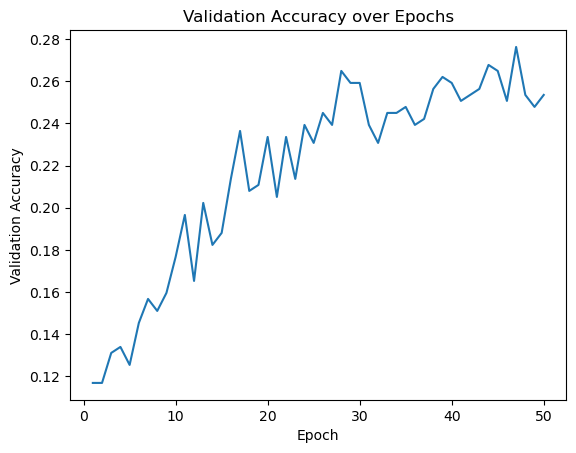

In [82]:
from matplotlib import pyplot as plt
plt.plot(range(1, num_epochs + 1), acc_list)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.show()

In [ ]:
classification_report(all_labels, all_preds, target_names=[artist for artist, idx in sorted(artist_mapping.items(), key=lambda x: x[1])])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'                      precision    recall  f1-score   support\n\n          Mac Miller       0.28      0.37      0.32        27\n      Kendrick Lamar       0.33      0.04      0.07        26\n      Quentin Miller       0.00      0.00      0.00        22\n               Drake       0.26      0.36      0.30        39\n             J. Cole       0.11      0.03      0.05        30\nA Tribe Called Quest       0.00      0.00      0.00        20\n          Kanye West       0.31      0.40      0.35        30\n          Soulja Boy       0.47      0.76      0.58        29\n               Jay-Z       0.09      0.12      0.10        26\n               Big L       0.60      0.14      0.22        22\n  Tyler, The Creator       0.29      0.08      0.12        26\n                2Pac       0.18      0.35      0.24        26\n         Joey Bada$$       0.17      0.43      0.25        28\n\n            accuracy                           0.25       351\n           macro avg       0.24      0.24      0.2

In [ ]:
test_dataset = dataset_to_bert(test_data['main_artist_lyrics_joined'].tolist(),
                           test_data['artist_id'].values)

yhats = []

embeddings_list = []

input_ids = [test_dataset[i][0] for i in range(len(test_dataset))]
attention_mask = [test_dataset[i][1] for i in range(len(test_dataset))]

for input_id, attention_m in zip(input_ids, attention_mask):
    input_id = input_id.unsqueeze(0).to(device)
    attention_m = attention_m.unsqueeze(0).to(device)
    bert_out = bert_model(input_ids=input_id, attention_mask=attention_m)
    embeddings = bert_out.pooler_output
    embeddings_list.append(embeddings)
    
    outputs = model(embeddings)
    preds = outputs.argmax(dim=1)

    yhats.extend(preds)

In [116]:
pred_art_lab = [list(artist_mapping.keys())[list(artist_mapping.values()).index(yhat.item())] for yhat in yhats]
act_art_lab = [list(artist_mapping.keys())[list(artist_mapping.values()).index(art_id)] for art_id in test_data['artist_id']]
test_data['act_artist'] = act_art_lab
test_data['pot_ghost_name'] = hip[hip['pot_ghost'] == 1]['pot_ghost_name'].values
test_data['predicted_artist'] = pred_art_lab

test_data

,main_artist_lyrics_joined,artist_id,act_artist,pot_ghost_name,predicted_artist
13,Yeah\nWoah-woah-woah-woah-woah-woah-woah-woah ...,0,Mac Miller,[J. Cole],Jay-Z
397,"I want to see you work out for me, work out fo...",4,J. Cole,[Kanye West],Drake
531,Dirt and grime and filth inside\nThe story of ...,6,Kanye West,[Drake],Kanye West
743,"\n\nUh, bloody murder, murder, murder\nBloody ...",8,Jay-Z,[Kanye West],2Pac
746,\nTake it how you want 'til a nigga dead\n'Til...,8,Jay-Z,[Kanye West],Joey Bada$$
748,"\nWe in the time of our lives, baby\nTurn the ...",8,Jay-Z,[Kanye West],Joey Bada$$
751,"Thank you, thank you very much for coming out ...",8,Jay-Z,[Kanye West],Joey Bada$$
768,"\nThank you, thank you, thank you!\nYou're far...",8,Jay-Z,[Kanye West],Joey Bada$$
776,"\nKanyeezy you did it again, you a genius, nig...",8,Jay-Z,[Kanye West],2Pac
780,"C'mon\nWoo\nR-O-C, we runnin' this rap shit\nM...",8,Jay-Z,[Kanye West],2Pac


In [ ]:
model_state_dict = model.state_dict()
PATH = "model_parameters.pth"
torch.save(model_state_dict, PATH)

## Bag of Words

Trying Bag of Words as simpler approach

Creating our BOW dictionary

In [486]:
def tokenize(string):
    wo_spec_char = re.sub(r'[^a-zA-Z0-9\s]','',string.lower())
    cleaned_tokens = re.split(r'\s',wo_spec_char)
    return cleaned_tokens

In [487]:
from collections import Counter
from scipy.sparse import csr_matrix

lyrics = train_data['main_artist_lyrics_joined']
for id, lyric in enumerate(lyrics):
    tokens = tokenize(lyric)
    
    if id == 0:
        bag_of_words = Counter(tokens)
        
    bag_of_words.update(tokens)
    
del bag_of_words['']
len(bag_of_words)

19714

Removing articles from the bag of words to hopefully learn from more meanigful words

In [488]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    lowercase=True,
    max_features=50000,     # recommended cap
    ngram_range=(1, 2)      # big improvement for lyrics
)

Creating a sparse matrix to then use this to train what words each artist is using

In [18]:
def sparse(input_data):
    gen_tokenized = [tokenize(lyric) for index, lyric in enumerate(input_data)]

    col_ind = []
    row_ind = []
    data = []
    vocabulary = {term: idx for idx, term in enumerate(bag_of_words.keys())}

    i = 0

    for g in gen_tokenized:
        for term in g:
            if term in vocabulary:
                index = vocabulary[term]
                col_ind.append(index)
                data.append(1)
                row_ind.append(i)
        i += 1

    sparse_mat = csr_matrix((data, (row_ind, col_ind)),shape = (len(input_data),len(vocabulary)), dtype=int).toarray()
    
    return sparse_mat, col_ind, row_ind, data

In [22]:
sparse_train = sparse(lyrics)
sparse_val = sparse(val_data['main_artist_lyrics_joined'])

In [489]:
def to_sparse_torch(row_ind, col_ind, data, input_data):
    i = torch.tensor([row_ind,col_ind], dtype = torch.long)
    d = torch.tensor(data)
    vocabulary = {term: idx for idx, term in enumerate(bag_of_words.keys())}
    return torch.sparse_coo_tensor(i,d,size = (len(input_data),len(vocabulary)), dtype = torch.float32)

In [492]:
#x_train = to_sparse_torch(sparse_train[2],sparse_train[1],sparse_train[3],train_data)
X_train = tfidf.fit_transform(train_data['main_artist_lyrics_joined'])
x_train = torch.sparse_csr_tensor(
    X_train.indptr,
    X_train.indices,
    X_train.data,
    size=X_train.shape,
    dtype=torch.float32
)
y_train = torch.tensor(train_data['artist_id'].values, dtype = torch.long)

#x_val = to_sparse_torch(sparse_val[2],sparse_val[1],sparse_val[3],val_data)
X_val = tfidf.transform(val_data['main_artist_lyrics_joined'])
x_val = torch.sparse_csr_tensor(
    X_val.indptr,
    X_val.indices,
    X_val.data,
    size=X_val.shape,
    dtype=torch.float32
)
y_val = torch.tensor(val_data['artist_id'].values,dtype=torch.long)

sgd_model = MultiClassRegression(x_train.shape[1], len(artist_mapping))

loss_fn = nn.CrossEntropyLoss()
optim_sgd = AdamW(sgd_model.parameters(), lr=1e-4)
num_epoch = 15

val_loss = []

random.seed(123)

for epoch in range(num_epoch):
    sgd_model.train()
    for step in range(len(train_data)):
        index = np.random.randint(0,len(train_data))
        x_batch = x_train[index].unsqueeze(0)
    
        predicted = sgd_model(x_batch)
        loss_sgd = loss_fn(predicted,y_train[index].unsqueeze(0))
        
        optim_sgd.zero_grad()
        loss_sgd.backward()
        optim_sgd.step()
        
    
    print(f'epoch:{epoch+1}, loss:{loss_sgd.item()}')

    sgd_model.eval()

    with torch.no_grad():
        predicted_val = sgd_model(x_val)
        
        pred_label=torch.argmax(predicted_val,dim=1)
        
        loss_val = loss_fn(predicted_val,y_val)
        val_loss.append(loss_val.item())
    
        val_acc = accuracy_score(y_val,pred_label)
        print(f'epoch:{epoch+1}, val_loss:{loss_val.item()}, val_acc:{val_acc}')


epoch:1, loss:2.3879036903381348
epoch:1, val_loss:2.466438055038452, val_acc:0.14333333333333334
epoch:2, loss:1.8742002248764038
epoch:2, val_loss:2.3532204627990723, val_acc:0.17666666666666667
epoch:3, loss:1.5978410243988037
epoch:3, val_loss:2.228461980819702, val_acc:0.23666666666666666
epoch:4, loss:1.2633718252182007
epoch:4, val_loss:2.091792583465576, val_acc:0.36
epoch:5, loss:1.2149658203125
epoch:5, val_loss:1.9526212215423584, val_acc:0.4633333333333333
epoch:6, loss:0.3062303066253662
epoch:6, val_loss:1.8172625303268433, val_acc:0.5533333333333333
epoch:7, loss:0.6737880706787109
epoch:7, val_loss:1.712465763092041, val_acc:0.6
epoch:8, loss:0.15177470445632935
epoch:8, val_loss:1.6090084314346313, val_acc:0.6133333333333333
epoch:9, loss:0.2304135262966156
epoch:9, val_loss:1.525812029838562, val_acc:0.6466666666666666
epoch:10, loss:0.00863721314817667
epoch:10, val_loss:1.4530296325683594, val_acc:0.62
epoch:11, loss:0.02351899817585945
epoch:11, val_loss:1.37511622

Non SGD

In [493]:
#x_train = to_sparse_torch(sparse_train[2],sparse_train[1],sparse_train[3],train_data)
X_train = tfidf.fit_transform(train_data['main_artist_lyrics_joined'])
x_train = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train = torch.tensor(train_data['artist_id'].values, dtype = torch.long)


X_val = tfidf.transform(val_data['main_artist_lyrics_joined'])
x_val   = torch.tensor(X_val.toarray(), dtype=torch.float32)
y_val = torch.tensor(val_data['artist_id'].values,dtype=torch.long)

model = MultiClassRegression(x_train.shape[1], len(artist_mapping))

loss_fn = nn.CrossEntropyLoss()
optim = AdamW(model.parameters(), lr=1e-4)
num_epoch = 5000

val_loss = []

random.seed(123)

for epoch in range(num_epoch):
    model.train()
    
    predicted = model(x_train)
    loss = loss_fn(predicted,y_train)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
        
    if epoch % 50 == 0:
        print(f'epoch:{epoch+1}, loss:{loss.item()}')

    model.eval()
    
    with torch.no_grad():
        predicted_val = model(x_val)
        
        pred_label = torch.argmax(predicted_val, dim=1)
        
        loss_val = loss_fn(predicted_val,y_val)
        val_loss.append(loss_val.item())
    
        val_acc = accuracy_score(y_val,pred_label)
        
        if epoch % 50 == 0:
            print(f'epoch:{epoch+1}, val_loss:{loss_val.item()}, val_acc:{val_acc}')


epoch:1, loss:2.5638225078582764
epoch:1, val_loss:2.563234806060791, val_acc:0.08333333333333333
epoch:51, loss:2.4233357906341553
epoch:51, val_loss:2.525841474533081, val_acc:0.2
epoch:101, loss:2.2248411178588867
epoch:101, val_loss:2.474231481552124, val_acc:0.32
epoch:151, loss:1.9793487787246704
epoch:151, val_loss:2.4108200073242188, val_acc:0.4
epoch:201, loss:1.6993547677993774
epoch:201, val_loss:2.3394484519958496, val_acc:0.4166666666666667
epoch:251, loss:1.4071238040924072
epoch:251, val_loss:2.264913320541382, val_acc:0.4166666666666667
epoch:301, loss:1.1290284395217896
epoch:301, val_loss:2.1916515827178955, val_acc:0.45
epoch:351, loss:0.8870767951011658
epoch:351, val_loss:2.123056650161743, val_acc:0.4666666666666667
epoch:401, loss:0.6920067071914673
epoch:401, val_loss:2.061190366744995, val_acc:0.4766666666666667
epoch:451, loss:0.5428417325019836
epoch:451, val_loss:2.0068154335021973, val_acc:0.5
epoch:501, loss:0.4317917227745056
epoch:501, val_loss:1.9597302

Trying it on the potentially ghost written data now

In [ ]:
#setting up data for model
#test_sparse = sparse(test_data['main_artist_lyrics_joined']) 

X_test = tfidf.transform(test_data['main_artist_lyrics_joined'])
x_test = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test = torch.tensor(test_data['artist_id'].values, dtype = torch.long)

#getting the predicted labels
predicted = model(x_test)
test_label = []

pred_sgd = sgd_model(x_test)
test_label_sgd = []

for i in range(len(predicted)):
    test_label.append(torch.argmax(predicted[i]))
    test_label_sgd.append(torch.argmax(pred_sgd[i]))
    
print(accuracy_score(y_test,test_label))
print(accuracy_score(y_test,test_label_sgd))

pred_art_lab = [list(artist_mapping.keys())[list(artist_mapping.values()).index(yhat.item())] for yhat in test_label]
act_art_lab = [list(artist_mapping.keys())[list(artist_mapping.values()).index(art_id)] for art_id in y_test.numpy()]

test_copy = test_data.copy()


test_copy['act_artist'] = act_art_lab
test_copy['song_title'] = hip.loc[test_data.index, 'song_title']
test_copy['pot_ghost_name'] = hip[hip['pot_ghost'] == 1]['pot_ghost_name'].values
test_copy['predicted_artist'] = pred_art_lab
test_copy['predicted_sgd'] = [list(artist_mapping.keys())[list(artist_mapping.values()).index(yhat.item())] for yhat in test_label_sgd]

test_copy

0.4666666666666667
0.8666666666666667


,main_artist_lyrics_joined,artist_id,act_artist,song_title,pot_ghost_name,predicted_artist,predicted_sgd
13,Yeah Woah-woah-woah-woah-woah-woah-woah-woah ...,0,Mac Miller,Hurt Feelings,[J. Cole],Mac Miller,Mac Miller
382,"I want to see you work out for me, work out fo...",4,J. Cole,Work Out,[Kanye West],Drake,J. Cole
474,Dirt and grime and filth inside The story of m...,6,Kanye West,Facts (Charlie Heat Version),[Drake],Kanye West,Kanye West
659,"Uh, bloody murder, murder, murder Bloody murd...",8,Jay-Z,Murder to Excellence,[Kanye West],Jay-Z,Jay-Z
662,Take it how you want 'til a nigga dead 'Til t...,8,Jay-Z,Illest Motherfucker Alive,[Kanye West],Jay-Z,Jay-Z
664,"We in the time of our lives, baby Turn the mu...",8,Jay-Z,Primetime,[Kanye West],Kanye West,Jay-Z
667,"Thank you, thank you very much for coming out ...",8,Jay-Z,Thank You,[Kanye West],"Tyler, The Creator","Tyler, The Creator"
683,"Thank you, thank you, thank you! You're far t...",8,Jay-Z,Encore,[Kanye West],Drake,Jay-Z
691,"Kanyeezy you did it again, you a genius, nigg...",8,Jay-Z,Lucifer,[Kanye West],Joey Bada$$,Jay-Z
695,"C'mon Woo R-O-C, we runnin' this rap shit Memp...",8,Jay-Z,Takeover,[Kanye West],J. Cole,Jay-Z


In [610]:
def get_ghost_score(row, predicted):
    get_art = hip.loc[row.name,'artist']
    ref_id = artist_mapping[get_art]
    ref_prob = predicted[ref_id]
    
    diff = predicted - ref_prob 
    sim = torch.tensor([1/(1+abs(d)) for d in diff])
    
    total = 0
    for i, s in enumerate(sim):
        if i != ref_id:
            total += s
    
    p_ghost = torch.tensor([s/total for s in sim])
    
    for i, p in enumerate(p_ghost):
        if i == ref_id:
            p_ghost[i] = -1
        p_ghost[i] = p
    
    return torch.max(p_ghost).tolist(), torch.argmax(p_ghost).tolist()

In [587]:
ghost_p_sgd = []
ghost_lab_sgd = []

ghost_p = []
ghost_lab = []

id_to_name = {v: k for k, v in artist_mapping.items()}

for i in range(len(test_copy)):
    p_ghost_sgd, ghost_label_sgd = get_ghost_score(test_copy.iloc[i,],pred_sgd[i])
    p_ghost, ghost_label = get_ghost_score(test_copy.iloc[i,],predicted[i])
    
    ghost_p_sgd.append(p_ghost_sgd)
    ghost_lab_sgd.append(id_to_name[ghost_label_sgd])
    
    ghost_p.append(p_ghost)
    ghost_lab.append(id_to_name[ghost_label])
    
test_copy['ghost prob sgd'] = ghost_p_sgd
test_copy['ghost prob lab sgd'] = ghost_lab_sgd
test_copy['ghost prob'] = ghost_p
test_copy['ghost prob lab'] = ghost_lab

test_copy

,main_artist_lyrics_joined,artist_id,act_artist,song_title,pot_ghost_name,predicted_artist,predicted_sgd,ghost prob sgd,ghost prob lab sgd,ghost prob,ghost prob lab
13,Yeah Woah-woah-woah-woah-woah-woah-woah-woah ...,0,Mac Miller,Hurt Feelings,[J. Cole],Mac Miller,Mac Miller,0.142383,Drake,0.105415,J. Cole
382,"I want to see you work out for me, work out fo...",4,J. Cole,Work Out,[Kanye West],Drake,J. Cole,0.266414,Drake,0.180625,Drake
474,Dirt and grime and filth inside The story of m...,6,Kanye West,Facts (Charlie Heat Version),[Drake],Kanye West,Kanye West,0.133916,Jay-Z,0.126541,Drake
659,"Uh, bloody murder, murder, murder Bloody murd...",8,Jay-Z,Murder to Excellence,[Kanye West],Jay-Z,Jay-Z,0.165322,Kanye West,0.198440,Kanye West
662,Take it how you want 'til a nigga dead 'Til t...,8,Jay-Z,Illest Motherfucker Alive,[Kanye West],Jay-Z,Jay-Z,0.150990,Kanye West,0.162320,Drake
664,"We in the time of our lives, baby Turn the mu...",8,Jay-Z,Primetime,[Kanye West],Kanye West,Jay-Z,0.217129,Kanye West,0.156613,"Tyler, The Creator"
667,"Thank you, thank you very much for coming out ...",8,Jay-Z,Thank You,[Kanye West],"Tyler, The Creator","Tyler, The Creator",0.137853,J. Cole,0.152586,Mac Miller
683,"Thank you, thank you, thank you! You're far t...",8,Jay-Z,Encore,[Kanye West],Drake,Jay-Z,0.130899,Drake,0.124492,J. Cole
691,"Kanyeezy you did it again, you a genius, nigg...",8,Jay-Z,Lucifer,[Kanye West],Joey Bada$$,Jay-Z,0.153846,Joey Bada$$,0.124360,Kanye West
695,"C'mon Woo R-O-C, we runnin' this rap shit Memp...",8,Jay-Z,Takeover,[Kanye West],J. Cole,Jay-Z,0.115033,J. Cole,0.132755,J. Cole


Comparing these scores to cases when we know for sure aren't ghost written

In [620]:
predicted = model(x_val)
test_label = []

pred_sgd = sgd_model(x_val)
test_label_sgd = []

for i in range(len(predicted)):
    test_label.append(torch.argmax(predicted[i]))
    test_label_sgd.append(torch.argmax(pred_sgd[i]))
    

print(accuracy_score(y_val,test_label))
print(accuracy_score(y_val,test_label_sgd))

ghost_p_sgd = []
ghost_lab_sgd = []

ghost_p = []
ghost_lab = []

val_copy = val_data.copy()

for i in range(len(val_copy)):
    p_ghost_sgd, ghost_label_sgd = get_ghost_score(val_copy.iloc[i,],pred_sgd[i])
    p_ghost, ghost_label = get_ghost_score(val_copy.iloc[i,],predicted[i])
    
    ghost_p_sgd.append(p_ghost_sgd)
    ghost_lab_sgd.append(id_to_name[ghost_label_sgd])
    
    ghost_p.append(p_ghost)
    ghost_lab.append(id_to_name[ghost_label])
    
    
val_copy['act_artist'] = [id_to_name[i] for i in val_copy['artist_id']]
val_copy['song_title'] = hip.loc[val_data.index, 'song_title']
val_copy['pred_artist sgd'] = [id_to_name[i.tolist()] for i in test_label_sgd]
val_copy['ghost prob sgd'] = ghost_p_sgd
val_copy['ghost prob lab sgd'] = ghost_lab_sgd
val_copy['ghost prob'] = ghost_p
val_copy['ghost prob lab'] = ghost_lab

val_copy

0.58
0.6766666666666666


,main_artist_lyrics_joined,artist_id,act_artist,song_title,pred_artist sgd,ghost prob sgd,ghost prob lab sgd,ghost prob,ghost prob lab
418,"Yeah, hey, look When she talks, she's so close...",4,J. Cole,Ladies,J. Cole,0.112980,Jay-Z,0.104585,"Tyler, The Creator"
1121,"Mmmmm, mmmmm Yeah, y’all know what this is M...",2,Quentin Miller,Broke My Heart,J. Cole,0.118555,Kanye West,0.121851,Kanye West
109,"At first, I did love you But now I just wann...",1,Kendrick Lamar,Wesley’s Theory,Jay-Z,0.168478,Kanye West,0.129318,Soulja Boy
1618,"Damn, Yeezy and Hov, where the hell you been?...",6,Kanye West,Otis,Jay-Z,0.149521,J. Cole,0.127047,Soulja Boy
1597,"Yeah, yeah I'm loyal to the soil I'd die for m...",12,Joey Bada$$,Left Hand,Joey Bada$$,0.119628,Kendrick Lamar,0.109009,Kendrick Lamar
...,...,...,...,...,...,...,...,...,...
208,"Yeah Nick Miles, Quentin Miller What a time, o...",2,Quentin Miller,To Turning 26...,Quentin Miller,0.202604,Drake,0.202616,Drake
1364,Draco EliTrill Soulja Rick and Morty P-P-Play...,7,Soulja Boy,Rick & Morty,Soulja Boy,0.134865,A Tribe Called Quest,0.101605,"Tyler, The Creator"
936,"*laughter* We going platinum nigga, we going p...",11,2Pac,5 Deadly Venomz,2Pac,0.136040,Jay-Z,0.100392,"Tyler, The Creator"
108,Why so sad? Walking around with them blue face...,1,Kendrick Lamar,untitled 08 | 09.06.2014.,Kendrick Lamar,0.204976,Drake,0.122725,Joey Bada$$


In [614]:
np.mean(val_copy['ghost prob sgd']), np.mean(test_copy['ghost prob sgd'])

(0.14272427399953205, 0.15621671626965206)

In [609]:
val_copy.iloc[0,].name

418

In [514]:
W = model.layer2.weight.detach().cpu().numpy()   # shape: (num_artists, vocab_size)

vocab_list = list(bag_of_words.keys())           # same order as your sparse vectors

top_words_per_artist = {}

for artist, idx in artist_mapping.items():
    artist_weights = W[idx]
    top_idx = np.argsort(-artist_weights)[:20]    # top positive weights
    top_words = [vocab_list[i] for i in top_idx]
    top_words_per_artist[artist] = top_words

top_words_per_artist


{'Mac Miller': ['they',
  'on',
  'foolish',
  'power',
  'mics',
  'like',
  'brothers',
  'tracks',
  'midtown',
  'peoples',
  'often',
  'life',
  'warn',
  'facts',
  'blocks',
  'sites',
  'so',
  'goes',
  'records',
  'busy'],
 'Kendrick Lamar': ['foolish',
  'never',
  'moves',
  'club',
  'blocks',
  'facts',
  'records',
  'across',
  'mics',
  'no',
  'over',
  'me',
  'life',
  'when',
  'better',
  'for',
  'wax',
  'bounce',
  'to',
  'this'],
 'Quentin Miller': ['beretta',
  'hot',
  'across',
  'and',
  'hustlin',
  'on',
  'yall',
  'cops',
  'club',
  'now',
  'brothers',
  'peoples',
  'sites',
  'when',
  'flop',
  'blow',
  'rocks',
  'bars',
  'real',
  'flooded'],
 'Drake': ['bars',
  'slept',
  'l',
  'cops',
  'harlem',
  'ruggedest',
  'out',
  'heads',
  'at',
  'we',
  'down',
  'club',
  'busy',
  'number',
  'walk',
  'makes',
  'blow',
  'cocked',
  'too',
  'leave'],
 'J. Cole': ['buyin',
  'down',
  'slept',
  'digits',
  'you',
  'uptown',
  'keep',
 

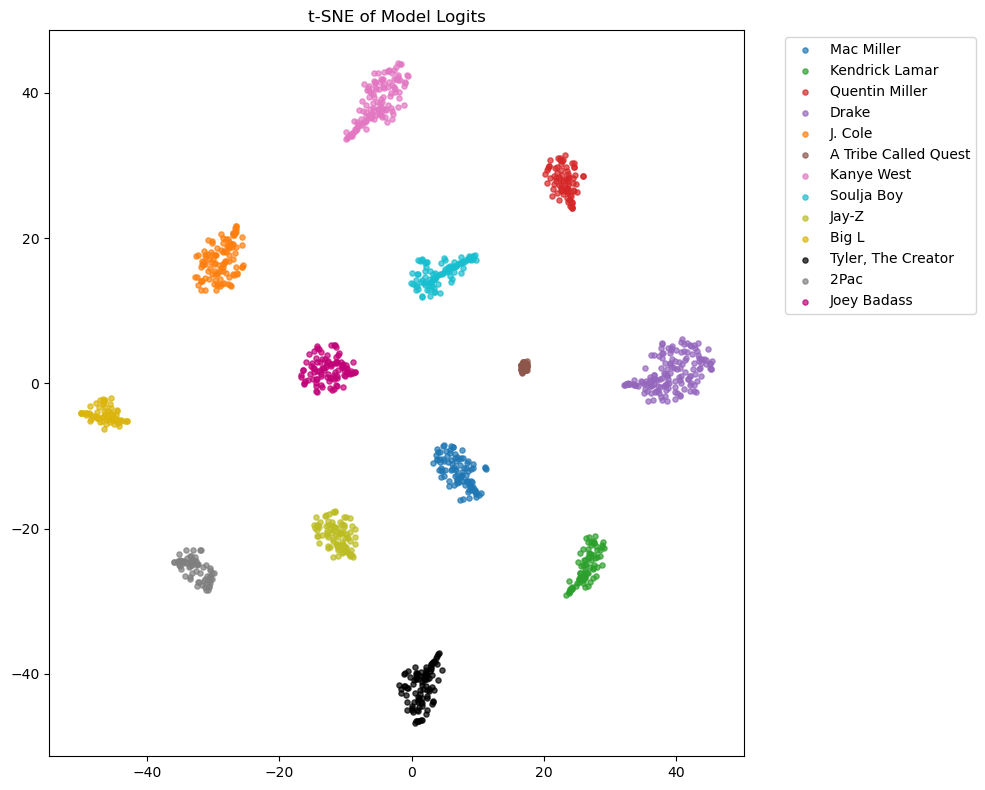

In [515]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# get logits for training data
with torch.no_grad():
    logits = model(x_train).cpu().numpy()

labels = train_data['artist_id'].values
id_to_name = {v: k for k, v in artist_mapping.items()}
id_to_name[12] = 'Joey Badass'

artist_id = list(id_to_name.keys())

colors = ['tab:blue',      # 0
    'tab:green',     # 1
    'tab:red',       # 2
    'tab:purple',    # 3
    'tab:orange',    # 4
    'tab:brown',     # 5
    'tab:pink',      # 6
    'tab:cyan',      # 7
    'tab:olive',     # 8
    'xkcd:gold',     # 9
    'black',      # 10
    'tab:gray',         # 11 <- for 2Pac
    'xkcd:magenta']  
emb = TSNE(n_components=2).fit_transform(logits)

plt.figure(figsize=(10,8))
for i, aid in enumerate(artist_id):
    idx = labels == aid
    plt.scatter(
        emb[idx, 0],
        emb[idx, 1],
        label=id_to_name[aid],
        s=14, alpha=0.7,
        color = colors[i]
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")  # move legend outside
plt.title("t-SNE of Model Logits")
plt.tight_layout()
plt.show()


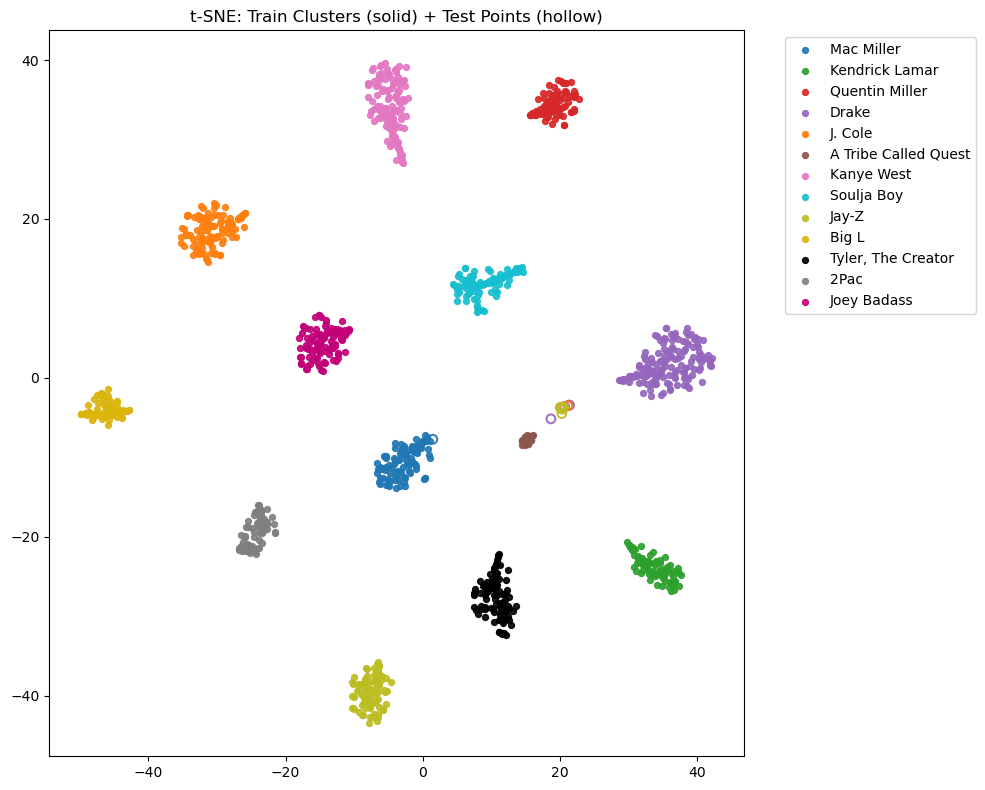

In [516]:
# get train & test logits
with torch.no_grad():
    train_logits = model(x_train).cpu().numpy()
    test_logits  = model(x_test).cpu().numpy()

train_labels = train_data['artist_id'].values
test_labels  = test_data['artist_id'].values

# combine
all_logits = np.vstack([train_logits, test_logits])

# one unified t-sne
emb_all = TSNE(n_components=2).fit_transform(all_logits)

# split back
emb_train = emb_all[:len(train_logits)]
emb_test  = emb_all[len(train_logits):]

# same artist ID → same color
artist_ids = sorted(id_to_name.keys())

colors = [
    'tab:blue','tab:green','tab:red','tab:purple','tab:orange',
    'tab:brown','tab:pink','tab:cyan','tab:olive','xkcd:gold',
    'black','tab:gray','xkcd:magenta'
]

plt.figure(figsize=(10,8))

for i, aid in enumerate(artist_ids):
    color = colors[i]
    
    # train points = solid
    tr_idx = train_labels == aid
    plt.scatter(
        emb_train[tr_idx,0], emb_train[tr_idx,1],
        color=color, s=18, alpha=0.9,
        label=id_to_name[aid] 
    )
    
    # test points = hollow circles
    te_idx = test_labels == aid
    plt.scatter(
        emb_test[te_idx,0], emb_test[te_idx,1],
        facecolors='none', edgecolors=color, s=40, linewidth=1.5, alpha=0.9
    )
    
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("t-SNE: Train Clusters (solid) + Test Points (hollow)")
plt.tight_layout()
plt.show()


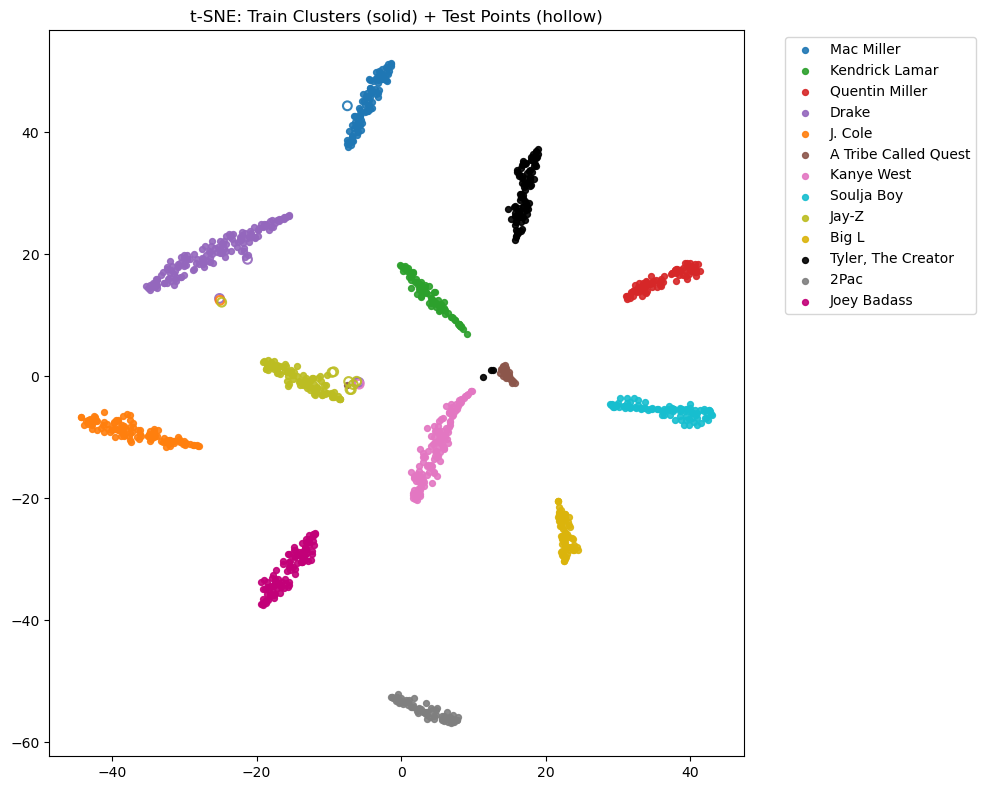

In [517]:
# get train & test logits
with torch.no_grad():
    train_logits = sgd_model(x_train).cpu().numpy()
    test_logits  = sgd_model(x_test).cpu().numpy()

train_labels = train_data['artist_id'].values
test_labels  = test_data['artist_id'].values

# combine
all_logits = np.vstack([train_logits, test_logits])

# one unified t-sne
emb_all = TSNE(n_components=2).fit_transform(all_logits)

# split back
emb_train = emb_all[:len(train_logits)]
emb_test  = emb_all[len(train_logits):]

# same artist ID → same color
artist_ids = sorted(id_to_name.keys())

colors = [
    'tab:blue','tab:green','tab:red','tab:purple','tab:orange',
    'tab:brown','tab:pink','tab:cyan','tab:olive','xkcd:gold',
    'black','tab:gray','xkcd:magenta'
]

plt.figure(figsize=(10,8))

for i, aid in enumerate(artist_ids):
    color = colors[i]
    
    # train points = solid
    tr_idx = train_labels == aid
    plt.scatter(
        emb_train[tr_idx,0], emb_train[tr_idx,1],
        color=color, s=18, alpha=0.9,
        label=id_to_name[aid] 
    )
    
    # test points = hollow circles
    te_idx = test_labels == aid
    plt.scatter(
        emb_test[te_idx,0], emb_test[te_idx,1],
        facecolors='none', edgecolors=color, s=40, linewidth=1.5, alpha=0.9
    )
    
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("t-SNE: Train Clusters (solid) + Test Points (hollow)")
plt.tight_layout()
plt.show()
